In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import ollama
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import requests
from tqdm import tqdm
import time

In [4]:
df = pd.read_csv('./data/manually_labelled.csv')
# print(df.head(2))

print('Length of DF: ', len(df))
print(df.isna().sum())

Length of DF:  246
category            146
post_date           146
post_title          146
comment_date        146
comment_votes       146
comment_body         69
comment_stance      181
comment_argument    169
dtype: int64


In [5]:
print(df.notna().sum())

category            100
post_date           100
post_title          100
comment_date        100
comment_votes       100
comment_body        177
comment_stance       65
comment_argument     77
dtype: int64


In [6]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)  
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return ''

def filter_bot(text):
    return isinstance(text, str) and 'i am a bot' in text.lower() #iamabot' in re.sub(r'\s+', '', text)

In [7]:
count = 0
for idx, text in df['comment_body'].items():
    cleaned_text = clean_text(text)
    if filter_bot(cleaned_text):
        count += 1
        print(cleaned_text)
        df.drop(idx, inplace=True)

print(count)

I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot. Any complaints suggestions to rContextualBot thanks
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
I am a bot, and this action was performed automatically. Please if you have any questions or concerns.
5


In [8]:
len(df[df['comment_body'].isna() & df['comment_stance'].isna()])

69

In [9]:
df[df['comment_stance'].isna() & df['comment_body'].notna()]['comment_body']

0      Snapshot of _Minister failing to act to reduce...
2      An archived version can be found [here](https:...
8      The amount of money wasted on completely bollo...
10     I once worked on a project that installed a ha...
15     So in other words smaller employers don’t need...
                             ...                        
234    We all know that ultimately the facts are that...
238    They just leave it.  You've got senior doctors...
240    People earning 50k will not bother applying fo...
242                       Is it incompetence?  Laziness?
245    Today's academia has so many failings - it act...
Name: comment_body, Length: 107, dtype: object

In [10]:
df = df[~df['comment_stance'].isna()]

In [11]:
df['comment_body']

6                    I used to work for a large council.
11     Such a stupid idea when the job market is alre...
12     I know this is a joke …right ? Come on someone...
13     I guess she missed the bit about employment al...
17      Wait....does he know he's not important anymore?
                             ...                        
223    The fact that over half of working Brits are n...
232    Not necessarily defending Labour herr but, Hon...
235    what the hell. When count average salary. It c...
236    The government have also made no attempt to fi...
243    The other side to this was a downplaying of tr...
Name: comment_body, Length: 65, dtype: object

In [12]:
df['comment_body'] = df['comment_body'].apply(clean_text)

In [13]:
def strip_content(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())

    try:
        stance_index = text.index('stance')
    except ValueError:
        stance_index = 0

    try:
        arg_index = text.index('rationale')
    except ValueError:
        arg_index = 0


    if arg_index>stance_index:
        stance_text = text[stance_index:arg_index]
    else:
        stance_text = text[stance_index:]

    stance = 'Disapprove' if 'disapprove' in stance_text else 'Approve'

    argument = text[arg_index:].split(' ')
    
    try:
        argument.remove('rationale')
    except:
        pass

    argument = ' '.join(argument)

    # stat_index = text.index('strategy')
    
    # stat = text[stat_index:].split(' ')
    # stat.remove('strategy')
    # stat = ' '.join(stat)

    return stance, argument#, stat

In [17]:
# LLM prompt template
def create_prompt(title, comment):
    return f"""You are an expert in political discourse analysis.

    Post Title: "{title}"
    Comment: "{comment}"

    Task 1: Does the comment AGREE or DISAGREE with the opinion expressed in the title? Reply only with 'approve', 'disapprove'.

    Task 2: Briefly explain the rationale behind the comment in 1-2 sentences.

    Respond in the following format:
    Stance: <stance>
    Rationale: <explanation>
    """


def query_ollama(prompt, mdl_idx):
    models_dict = {0: 'gemma3:27b-it-qat', 1: 'gemma3:12b', 2: 'gemma3:4b', 3: 'deepseek-r1:8b'}
    url = "http://localhost:11434/api/generate"
    data = {
        "model": models_dict[mdl_idx],
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(url, json=data)
        response.raise_for_status()
        return response.json()["response"]
    except Exception as e:
        print("Error:", e)
        return None

In [18]:
def apply_on_df(df):
    selected_mdl_idx = 0
    for idx, row in tqdm(df.iterrows(), desc='Processing: ', total=len(df), dynamic_ncols=True):
        prompt = create_prompt(row['post_title'], row['comment_body'])
        llm_response = query_ollama(prompt, selected_mdl_idx)

        if llm_response:
            stance, argument = strip_content(llm_response)
            df.at[idx, 'llm_stance'] = stance.lower() 
            df.at[idx, 'llm_argument'] = argument.lower() 
   
        time.sleep(1)

    return df

In [ ]:
result_df = apply_on_df(df)
result_df.to_csv('data/llm_labelled_27bqt.csv')

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [16]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (DeepSeek-R1:8b):', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (DeepSeek-R1:8b): 0.7076923076923077
classification Report:
              precision    recall  f1-score   support

     approve       0.56      0.68      0.61        22
  disapprove       0.82      0.72      0.77        43

    accuracy                           0.71        65
   macro avg       0.69      0.70      0.69        65
weighted avg       0.73      0.71      0.71        65



In [14]:
result_df = pd.read_csv('./data/llm_labelled.csv')
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:12b):', acc_score)
print('classification Report:')
print(clf_report)

Accuracy Score (Gemma3:12b): 0.8307692307692308
classification Report:
              precision    recall  f1-score   support

     approve       0.74      0.77      0.76        22
  disapprove       0.88      0.86      0.87        43

    accuracy                           0.83        65
   macro avg       0.81      0.82      0.81        65
weighted avg       0.83      0.83      0.83        65



In [ ]:
ytrue, ypred = result_df['comment_stance'], result_df['llm_stance'].map(str.lower)
acc_score = accuracy_score(ytrue, ypred)
clf_report = classification_report(ytrue, ypred)
cm = confusion_matrix(ytrue, ypred)

print('Accuracy Score (Gemma3:27b):', acc_score)
print('classification Report:')
print(clf_report)

Text(50.722222222222214, 0.5, 'LLM Labels')

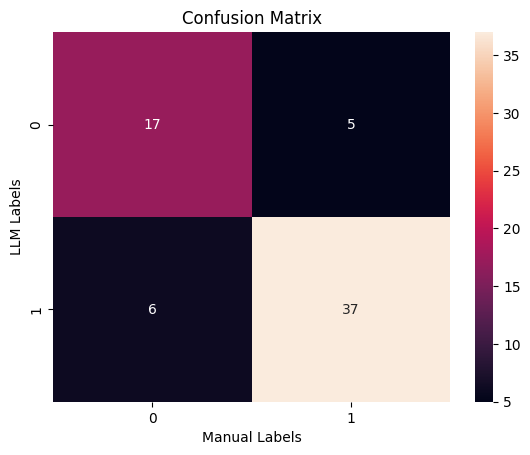

In [15]:
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Manual Labels')
plt.ylabel('LLM Labels')